#1. Data Loading and Cleaning

In [ ]:
%%capture
!pip install catboost
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
import geopy.distance
import pickle
import warnings
from datetime import datetime, timedelta
import optuna
from optuna.samplers import TPESampler
import joblib
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load all datasets
print("🔄 Loading datasets...")

df_viajes = pd.read_csv("mbtb_viajes2021.csv")
df_estaciones = pd.read_csv("mbtb_estaciones2021.csv")
df_vehiculos = pd.read_excel("mbtb_vehiculos2021.xlsx")
df_fueraserv = pd.read_csv("mbtb_fueraserv2021.csv")
df_estadocarga = pd.read_csv("mbtb_estadocarga2021.csv")

🔄 Loading datasets...


In [ ]:
datasets = {
    "Trips (viajes)": df_viajes,
    "Stations (estaciones)": df_estaciones,
    "Vehicles (vehiculos)": df_vehiculos,
    "Out of Service (fueraserv)": df_fueraserv,
    "Station Status(estadocarga)": df_estadocarga
}

#EDA

In [ ]:
print("📊 Dataset Overview:")
print("=" * 50)
for name, df in datasets.items():
    print(f"{name:.<30} {df.shape[0]:>6,} rows × {df.shape[1]:>2} cols")

📊 Dataset Overview:
Trips (viajes)................ 1,187,292 rows × 27 cols
Stations (estaciones).........     72 rows ×  8 cols
Vehicles (vehiculos).......... 12,346 rows ×  7 cols
Out of Service (fueraserv)....  3,394 rows ×  5 cols
Station Status(estadocarga)... 154,503 rows × 14 cols


In [ ]:
# Let's examine the structure of our main datasets
print("🔍 Examining Trips Dataset Structure:")
print("=" * 40)
print(df_viajes.head())
print(f"\nColumns: {list(df_viajes.columns)}")
print(f"\nData types:")
print(df_viajes.dtypes)

🔍 Examining Trips Dataset Structure:
        id  user_id  bike_id  origin_station_id close_type  \
0  3122780   271400     1065                 36       Auto   
1  3122785   260707      957                 22       Auto   
2  3122779   266240     1079                  4       Auto   
3  3122778   229628      214                 36       Auto   
4  3122793   185816     1056                 17       Auto   

   origin_anchor_index origin_date origin_date_name  origin_month  \
0                    6  2021-01-01           Friday             1   
1                   10  2021-01-01           Friday             1   
2                   11  2021-01-01           Friday             1   
3                   17  2021-01-01           Friday             1   
4                   14  2021-01-01           Friday             1   

  origin_month_name  ... country_id  user_type  nationality   age gender  \
0           January  ...         17       MOVI          ARG  37.0      M   
1           January  ..

In [ ]:
print("🏢 Station Dataset Overview:")
print("=" * 30)
print(df_estaciones.head())
print(f"\nTotal stations: {len(df_estaciones)}")

🏢 Station Dataset Overview:
   id  station_code                name  \
0   1             1    Museo Castagnino   
1   2             2    Paseo Pellegrini   
2   3             3         Plaza López   
3   4             4  Fac. de Ingeniería   
4   5             5      Ciudad Univ. I   

                              description              address        lat  \
0        Museo Castagnino, Bv. Oroño 1675           Oroño 1658 -32.954214   
1   Paseo Pellegrini, Av. Pellegrini 1365  Av. Pellegrini 1377 -32.956663   
2            Plaza López, Pellegrini  779      Pellegrini  779 -32.958121   
3  Fac. de Ingeniería, Av. Pellegrini 280   Av. Pellegrini 280 -32.959215   
4        Ciudad Univ. I, Riobamba 239 BIS     Riobamba 239 BIS -32.967366   

         lon  capacity  
0 -60.655987        20  
1 -60.644869        20  
2 -60.636702        20  
3 -60.629449        20  
4 -60.623572        21  

Total stations: 72
Unique station types: No type column


In [ ]:
# First, let's check for missing values across all datasets
print("🔍 Missing Values Analysis:")
print("=" * 30)

for name, df in datasets.items():
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

    if len(missing_df) > 0:
        print(f"\n{name}:")
        print(missing_df)
    else:
        print(f"\n{name}: No missing values! ✅")

🔍 Missing Values Analysis:

Trips (viajes):
     Missing Count  Missing %
age             22   0.001853

Stations (estaciones): No missing values! ✅

Vehicles (vehiculos):
                            Missing Count  Missing %
Desestimar                           8661  70.152276
Tiempo de permanencia                  13   0.105297
Fecha hora salida de zona               7   0.056699
Fecha hora entrada de zona              6   0.048599

Out of Service (fueraserv): No missing values! ✅

Station Status(estadocarga): No missing values! ✅


In [ ]:
# We mantain only if desestimar is NaN
df_vehiculos = df_vehiculos[df_vehiculos['Desestimar'].isna()]
df_vehiculos.drop('Desestimar', axis=1, inplace=True)

In [ ]:
# Let's clean the trips data step by step
print("🧹 Cleaning Trips Data...")

# Make a copy to preserve original
df_viajes_clean = df_viajes.copy()

print(f"Original shape: {df_viajes_clean.shape}")

# Step 1: Remove columns that won't be useful for our analysis
print("\n📋 Dropping unnecessary columns...")
columns_to_drop = ["user_id", "id", "age", "gender", "nationality",
                  "user_type", "country_id", "origin_month_name",
                  "user_type_id", "bike_id", "close_type"]

# Only drop columns that actually exist
existing_cols_to_drop = [col for col in columns_to_drop if col in df_viajes_clean.columns]
df_viajes_clean = df_viajes_clean.drop(columns=existing_cols_to_drop)
print(f"Dropped {len(existing_cols_to_drop)} columns: {existing_cols_to_drop}")

# Step 2: Focus on Q4 2021 (October-December) as recommended
print("\n📅 Filtering to Q4 2021 (Oct-Dec)...")
df_viajes_clean = df_viajes_clean[df_viajes_clean["origin_month"].isin([10, 11, 12])]
print(f"After Q4 filter: {df_viajes_clean.shape}")

# Step 3: Remove trips involving non-existent stations
print("\n🚫 Removing invalid stations...")
invalid_stations = [55, 56, 86]  # These stations don't exist in our station data

for station in invalid_stations:
    before_count = len(df_viajes_clean)
    df_viajes_clean = df_viajes_clean[
        (df_viajes_clean["destination_station_id"] != station) &
        (df_viajes_clean["origin_station_id"] != station)
    ]
    removed = before_count - len(df_viajes_clean)
    if removed > 0:
        print(f"Removed {removed} trips involving station {station}")

print(f"Final cleaned trips shape: {df_viajes_clean.shape}")

🧹 Cleaning Trips Data...
Original shape: (1187292, 27)

📋 Dropping unnecessary columns...
Dropped 11 columns: ['user_id', 'id', 'age', 'gender', 'nationality', 'user_type', 'country_id', 'origin_month_name', 'user_type_id', 'bike_id', 'close_type']

📅 Filtering to Q4 2021 (Oct-Dec)...
After Q4 filter: (353557, 16)

🚫 Removing invalid stations...
Removed 1 trips involving station 55
Removed 1 trips involving station 86
Final cleaned trips shape: (353555, 16)


In [ ]:
# Step 4: Parse and process date/time columns
print("🕐 Processing date and time columns...")

# Convert date columns
df_viajes_clean["origin_date"] = pd.to_datetime(df_viajes_clean["origin_date"])
df_viajes_clean["destination_date"] = pd.to_datetime(df_viajes_clean["destination_date"])

# Convert time columns to datetime for easier manipulation
df_viajes_clean["origin_time_dt"] = pd.to_datetime(df_viajes_clean["origin_time"], format="%H:%M:%S")
df_viajes_clean["destination_time_dt"] = pd.to_datetime(df_viajes_clean["destination_time"], format="%H:%M:%S")

# Create rounded time columns (30-minute intervals for aggregation)
df_viajes_clean["hora_salida_redondeada"] = df_viajes_clean["origin_time_dt"].dt.round("30min").dt.strftime('%H:%M')
df_viajes_clean["hora_llegada_redondeada"] = df_viajes_clean["destination_time_dt"].dt.round("30min").dt.strftime('%H:%M')

# Add day names for easier analysis
df_viajes_clean["dia_salida"] = df_viajes_clean['origin_date'].dt.day_name()
df_viajes_clean["dia_llegada"] = df_viajes_clean['destination_date'].dt.day_name()

print("✅ Date/time processing complete!")
print(f"Date range: {df_viajes_clean['origin_date'].min()} to {df_viajes_clean['origin_date'].max()}")
print(f"Sample of rounded times: {df_viajes_clean['hora_salida_redondeada'].unique()[:10]}")

🕐 Processing date and time columns...
✅ Date/time processing complete!
Date range: 2021-10-01 00:00:00 to 2021-12-31 00:00:00
Sample of rounded times: ['00:00' '00:30' '01:00' '01:30' '02:00' '02:30' '03:00' '03:30' '04:00'
 '04:30']


In [ ]:
# Clean the station status data
print("🧹 Cleaning Station Status Data...")

df_estadocarga_clean = df_estadocarga.copy()
print(f"Original shape: {df_estadocarga_clean.shape}")

# Remove invalid stations
invalid_stations = [55, 56, 86]
df_estadocarga_clean = df_estadocarga_clean[~df_estadocarga_clean["id_station"].isin(invalid_stations)]

# Drop unnecessary columns
unnecessary_cols = ["id", "station_num", "is_deleted", "incidence_time", "id_status_for_station"]
existing_unnecessary = [col for col in unnecessary_cols if col in df_estadocarga_clean.columns]
df_estadocarga_clean = df_estadocarga_clean.drop(columns=existing_unnecessary)

# Convert date columns
df_estadocarga_clean["created_at"] = pd.to_datetime(df_estadocarga_clean["created_at"])
if "incidence_end_date" in df_estadocarga_clean.columns:
    df_estadocarga_clean["incidence_end_date"] = pd.to_datetime(df_estadocarga_clean["incidence_end_date"])

# Filter to Q4 2021
df_estadocarga_clean = df_estadocarga_clean[df_estadocarga_clean["created_at"] >= "2021-10-01"]

# Create time-based features
df_estadocarga_clean["hora_inicio"] = df_estadocarga_clean["created_at"].dt.round("30min").dt.strftime('%H:%M')
df_estadocarga_clean["dia"] = df_estadocarga_clean["created_at"].dt.day_name()
df_estadocarga_clean["mes"] = df_estadocarga_clean["created_at"].dt.month

print(f"Cleaned station status shape: {df_estadocarga_clean.shape}")

🧹 Cleaning Station Status Data...
Original shape: (154503, 14)
Cleaned station status shape: (40307, 12)


In [ ]:
# Clean the out-of-service data
print("🧹 Cleaning Out-of-Service Data...")

df_fueraserv_clean = df_fueraserv.copy()
print(f"Original shape: {df_fueraserv_clean.shape}")

# Remove test and mobile stations
invalid_stations_extended = [501, 502, 503, 55, 56, 86]
if "Número" in df_fueraserv_clean.columns:
    df_fueraserv_clean = df_fueraserv_clean[~df_fueraserv_clean["Número"].isin(invalid_stations_extended)]

# Convert date columns (handling different possible formats)
date_cols = ["Desde", "Hasta"]
for col in date_cols:
    if col in df_fueraserv_clean.columns:
        try:
            df_fueraserv_clean[col] = pd.to_datetime(df_fueraserv_clean[col], format='%d-%m-%Y %H:%M:%S')
        except:
            df_fueraserv_clean[col] = pd.to_datetime(df_fueraserv_clean[col])

# Filter to Q4 2021
if "Desde" in df_fueraserv_clean.columns:
    df_fueraserv_clean = df_fueraserv_clean[df_fueraserv_clean["Desde"] >= "2021-10-01"]

# Remove extremely long incidents (>5 days) as they likely indicate other issues
if "Duración" in df_fueraserv_clean.columns:
    df_fueraserv_clean = df_fueraserv_clean[df_fueraserv_clean["Duración"] < 7200]  # 5 days in minutes

print(f"Cleaned out-of-service shape: {df_fueraserv_clean.shape}")

🧹 Cleaning Out-of-Service Data...
Original shape: (3394, 5)
Cleaned out-of-service shape: (420, 5)


In [ ]:
# Overall trip statistics
print("🚴‍♂️ TRIP ANALYSIS OVERVIEW")
print("=" * 50)
print(f"📈 Total trips in Q4 2021: {len(df_viajes_clean):,}")
print(f"🏢 Unique origin stations: {df_viajes_clean['origin_station_id'].nunique()}")
print(f"🎯 Unique destination stations: {df_viajes_clean['destination_station_id'].nunique()}")
print(f"📅 Date range: {df_viajes_clean['origin_date'].min().strftime('%Y-%m-%d')} to {df_viajes_clean['origin_date'].max().strftime('%Y-%m-%d')}")
print(f"⏱️ Average trip duration: {df_viajes_clean['time_minutes'].mean():.1f} minutes")
print(f"🔄 Median trip duration: {df_viajes_clean['time_minutes'].median():.1f} minutes")

🚴‍♂️ TRIP ANALYSIS OVERVIEW
📈 Total trips in Q4 2021: 353,555
🏢 Unique origin stations: 72
🎯 Unique destination stations: 72
📅 Date range: 2021-10-01 to 2021-12-31
⏱️ Average trip duration: 22.2 minutes
🔄 Median trip duration: 15.8 minutes


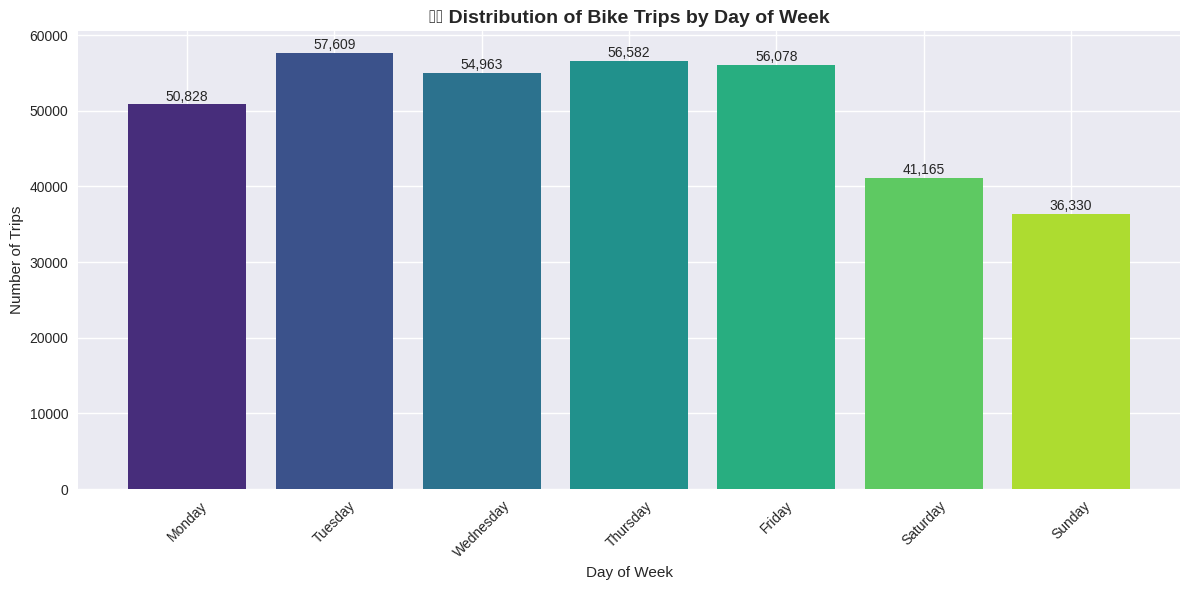

📊 Daily trip statistics:
Monday: 50,828 trips (14.4%)
Tuesday: 57,609 trips (16.3%)
Wednesday: 54,963 trips (15.5%)
Thursday: 56,582 trips (16.0%)
Friday: 56,078 trips (15.9%)
Saturday: 41,165 trips (11.6%)
Sunday: 36,330 trips (10.3%)


In [ ]:
# Distribution of trips by day of week
plt.figure(figsize=(12, 6))

# Count trips by day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_viajes_clean['dia_salida'].value_counts()
day_counts = day_counts.reindex(day_order)

# Create bar plot
bars = plt.bar(day_counts.index, day_counts.values, color=sns.color_palette("viridis", len(day_counts)))
plt.title('🗓️ Distribution of Bike Trips by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("📊 Daily trip statistics:")
for day, count in day_counts.items():
    percentage = (count / day_counts.sum()) * 100
    print(f"{day}: {count:,} trips ({percentage:.1f}%)")


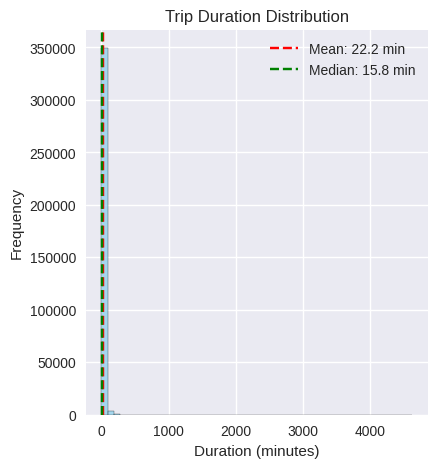

In [ ]:
# Trip duration analysis
plt.figure(figsize=(15, 5))

# Plot 1: Trip duration histogram
plt.subplot(1, 3, 1)
plt.hist(df_viajes_clean['time_minutes'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.axvline(df_viajes_clean['time_minutes'].mean(), color='red', linestyle='--', label=f'Mean: {df_viajes_clean["time_minutes"].mean():.1f} min')
plt.axvline(df_viajes_clean['time_minutes'].median(), color='green', linestyle='--', label=f'Median: {df_viajes_clean["time_minutes"].median():.1f} min')
plt.legend()


In [ ]:
# We drop trips longer than 150 minutes
df_viajes_clean = df_viajes_clean[df_viajes_clean['time_minutes'] <= 150]

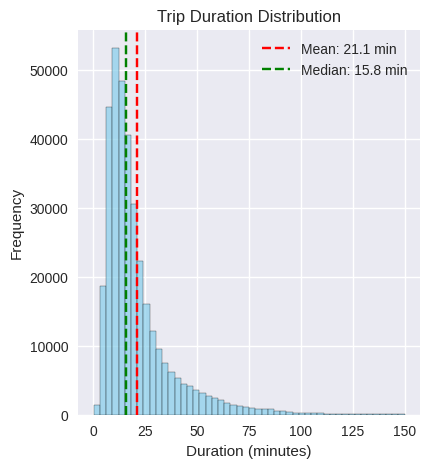

In [ ]:
# Trip duration analysis
plt.figure(figsize=(15, 5))

# Plot 1: Trip duration histogram
plt.subplot(1, 3, 1)
plt.hist(df_viajes_clean['time_minutes'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.axvline(df_viajes_clean['time_minutes'].mean(), color='red', linestyle='--', label=f'Mean: {df_viajes_clean["time_minutes"].mean():.1f} min')
plt.axvline(df_viajes_clean['time_minutes'].median(), color='green', linestyle='--', label=f'Median: {df_viajes_clean["time_minutes"].median():.1f} min')
plt.legend()


Text(0, 0.5, 'Duration (minutes)')

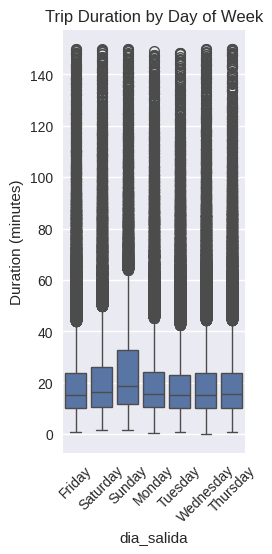

In [ ]:
# Plot 2: Box plot of duration by day of week
plt.subplot(1, 3, 2)
sns.boxplot(data=df_viajes_clean, x='dia_salida', y='time_minutes', )
plt.title('Trip Duration by Day of Week')
plt.xticks(rotation=45)
plt.ylabel('Duration (minutes)')


In [ ]:
# Plot 3: Duration vs hour of day
df_viajes_clean['hour'] = df_viajes_clean['origin_time_dt'].dt.hour
hourly_duration = df_viajes_clean.groupby('hour')['time_minutes'].mean()


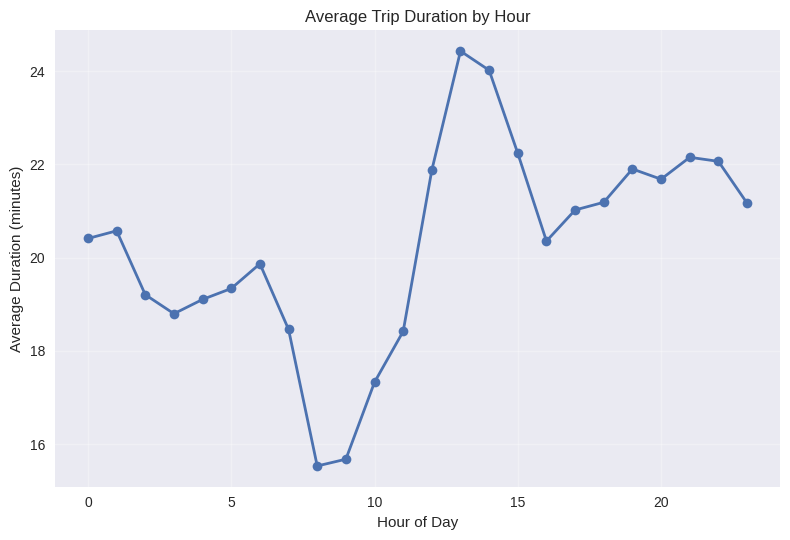

In [ ]:
plt.plot(hourly_duration.index, hourly_duration.values, marker='o', linewidth=2)
plt.title('Average Trip Duration by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (minutes)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Station usage analysis
print("🏢 STATION USAGE ANALYSIS")
print("=" * 30)

# Calculate station statistics
station_usage_origin = df_viajes_clean.groupby('origin_station_id').agg({
    'time_minutes': ['count', 'mean', 'std'],
    'destination_station_id': 'nunique'
}).round(2)

station_usage_origin.columns = ['total_trips', 'avg_duration', 'std_duration', 'unique_destinations']
station_usage_origin = station_usage_origin.reset_index()

# Merge with station info
station_usage_origin = station_usage_origin.merge(
    df_estaciones[['id', 'name', 'capacity']],
    left_on='origin_station_id',
    right_on='id',
    how='left'
)

# Top 10 most used stations
print("🔝 Top 10 Most Used Stations (Origin):")
top_stations = station_usage_origin.nlargest(10, 'total_trips')
for idx, row in top_stations.iterrows():
    print(f"{row['name']:<40} {row['total_trips']:>6,} trips")

🏢 STATION USAGE ANALYSIS
🔝 Top 10 Most Used Stations (Origin):
Plaza Sarmiento                          12,967 trips
Paseo Pellegrini                         12,733 trips
Plaza López                              12,353 trips
Pichincha                                12,111 trips
Fac. Ciencias Económicas                 11,005 trips
Plaza Cooperación                        10,877 trips
Terminal                                 10,384 trips
Paseo Pellegrini II                      10,325 trips
Plaza Montenegro                          9,874 trips
Fac. de Ingeniería                        9,675 trips


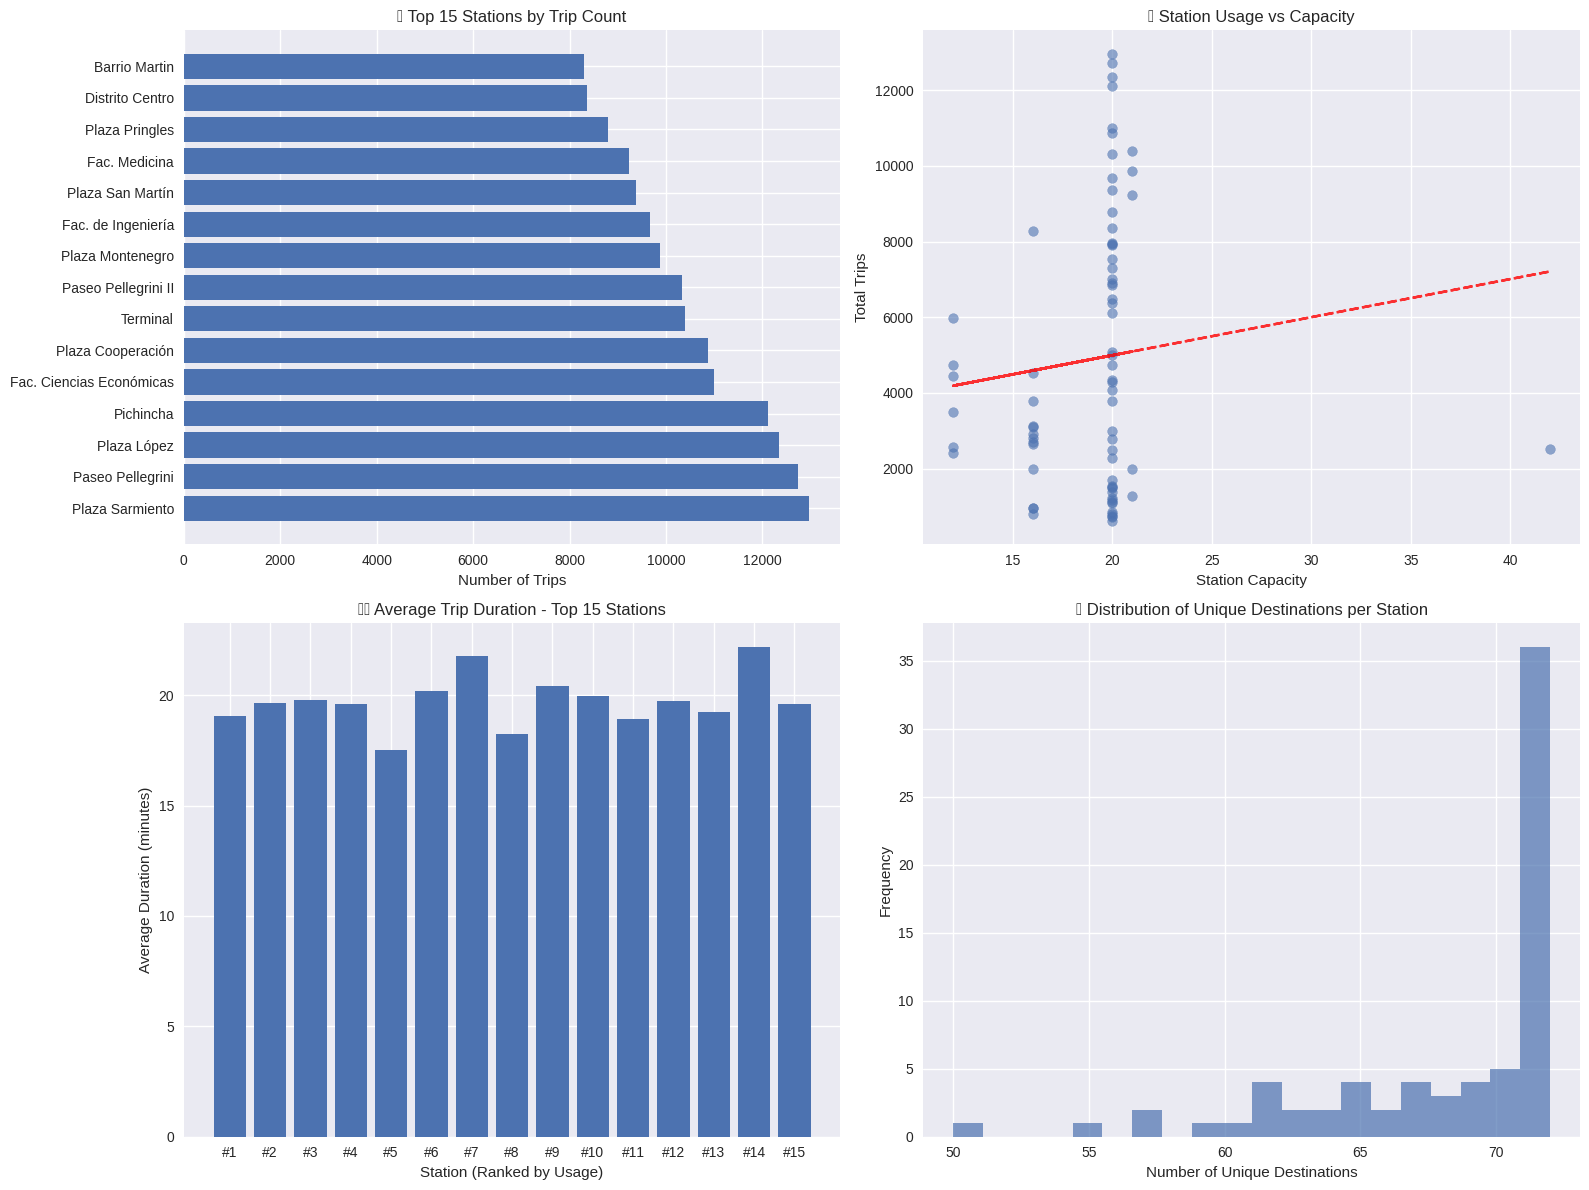

In [ ]:
# Visualize station usage patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 15 stations by usage
top_15 = station_usage_origin.nlargest(15, 'total_trips')
axes[0, 0].barh(top_15['name'], top_15['total_trips'])
axes[0, 0].set_title('🏆 Top 15 Stations by Trip Count')
axes[0, 0].set_xlabel('Number of Trips')

# Plot 2: Usage vs Capacity
axes[0, 1].scatter(station_usage_origin['capacity'], station_usage_origin['total_trips'], alpha=0.6)
axes[0, 1].set_xlabel('Station Capacity')
axes[0, 1].set_ylabel('Total Trips')
axes[0, 1].set_title('📊 Station Usage vs Capacity')

# Add trend line
z = np.polyfit(station_usage_origin['capacity'].fillna(0), station_usage_origin['total_trips'], 1)
p = np.poly1d(z)
axes[0, 1].plot(station_usage_origin['capacity'].fillna(0), p(station_usage_origin['capacity'].fillna(0)), "r--", alpha=0.8)

# Plot 3: Average trip duration by station (top 15)
axes[1, 0].bar(range(len(top_15)), top_15['avg_duration'])
axes[1, 0].set_title('⏱️ Average Trip Duration - Top 15 Stations')
axes[1, 0].set_xlabel('Station (Ranked by Usage)')
axes[1, 0].set_ylabel('Average Duration (minutes)')
axes[1, 0].set_xticks(range(len(top_15)))
axes[1, 0].set_xticklabels([f"#{i+1}" for i in range(len(top_15))])

# Plot 4: Number of unique destinations
axes[1, 1].hist(station_usage_origin['unique_destinations'], bins=20, alpha=0.7)
axes[1, 1].set_title('🎯 Distribution of Unique Destinations per Station')
axes[1, 1].set_xlabel('Number of Unique Destinations')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

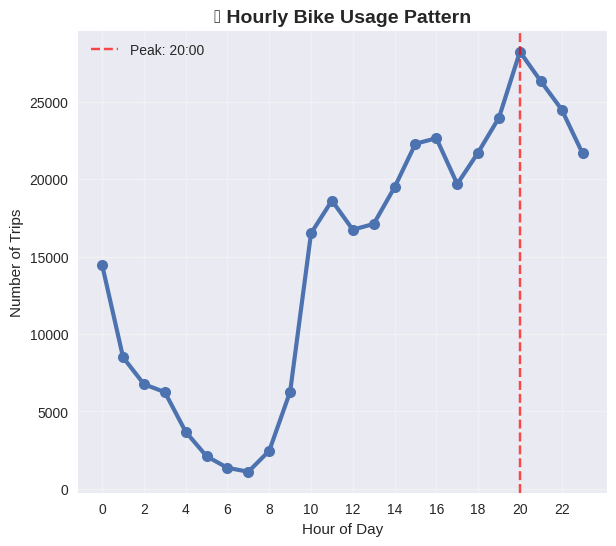

In [ ]:
# Hourly usage patterns
hourly_usage = df_viajes_clean.groupby(df_viajes_clean['origin_time_dt'].dt.hour).size()

plt.figure(figsize=(15, 6))

# Plot 1: Hourly usage pattern
plt.subplot(1, 2, 1)
plt.plot(hourly_usage.index, hourly_usage.values, marker='o', linewidth=3, markersize=8)
plt.title('🕐 Hourly Bike Usage Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Highlight peak hours
peak_hour = hourly_usage.idxmax()
plt.axvline(peak_hour, color='red', linestyle='--', alpha=0.7, label=f'Peak: {peak_hour}:00')
plt.legend()

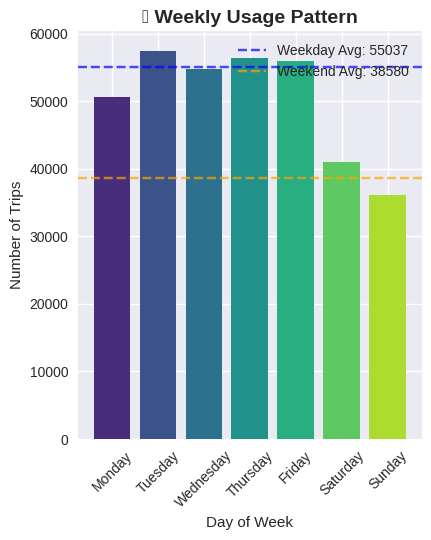

In [ ]:
# Plot 2: Weekly pattern
plt.subplot(1, 2, 2)
weekly_usage = df_viajes_clean.groupby('dia_salida').size().reindex(day_order)
bars = plt.bar(weekly_usage.index, weekly_usage.values, color=sns.color_palette("viridis", len(weekly_usage)))
plt.title('📅 Weekly Usage Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)

# Highlight weekend vs weekday
weekday_avg = weekly_usage[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean()
weekend_avg = weekly_usage[['Saturday', 'Sunday']].mean()
plt.axhline(weekday_avg, color='blue', linestyle='--', alpha=0.7, label=f'Weekday Avg: {weekday_avg:.0f}')
plt.axhline(weekend_avg, color='orange', linestyle='--', alpha=0.7, label=f'Weekend Avg: {weekend_avg:.0f}')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(f"🔥 Peak usage hour: {peak_hour}:00 with {hourly_usage.max():,} trips")
print(f"📊 Weekday average: {weekday_avg:.0f} trips/day")
print(f"🎉 Weekend average: {weekend_avg:.0f} trips/day")
print(f"📈 Weekday vs Weekend ratio: {weekday_avg/weekend_avg:.2f}x")


🔥 Peak usage hour: 20:00 with 28,225 trips
📊 Weekday average: 55037 trips/day
🎉 Weekend average: 38580 trips/day
📈 Weekday vs Weekend ratio: 1.43x


# Feature Engineering

In [ ]:
print("🔧 FEATURE ENGINEERING")
print("=" * 25)

# Start with a copy of clean data
df_viajes_fe = df_viajes_clean.copy()

print("1️⃣ Creating time-based features...")

# Basic time features
df_viajes_fe['origin_hour'] = df_viajes_fe['origin_time_dt'].dt.hour
df_viajes_fe['origin_minute'] = df_viajes_fe['origin_time_dt'].dt.minute
df_viajes_fe['origin_weekday'] = df_viajes_fe['origin_date'].dt.weekday  # 0=Monday, 6=Sunday

# Cyclical encoding (very important for time features!)
# This helps ML models understand that 23:59 and 00:01 are close in time
print("   ⭕ Creating cyclical time encodings...")

# Hour cyclical features
df_viajes_fe['hour_sin'] = np.sin(2 * np.pi * df_viajes_fe['origin_hour'] / 24)
df_viajes_fe['hour_cos'] = np.cos(2 * np.pi * df_viajes_fe['origin_hour'] / 24)

# Day of week cyclical features
df_viajes_fe['weekday_sin'] = np.sin(2 * np.pi * df_viajes_fe['origin_weekday'] / 7)
df_viajes_fe['weekday_cos'] = np.cos(2 * np.pi * df_viajes_fe['origin_weekday'] / 7)

# Month cyclical features
df_viajes_fe['month_sin'] = np.sin(2 * np.pi * df_viajes_fe['origin_month'] / 12)
df_viajes_fe['month_cos'] = np.cos(2 * np.pi * df_viajes_fe['origin_month'] / 12)

print("   ✅ Cyclical features created!")

🔧 FEATURE ENGINEERING
1️⃣ Creating time-based features...
   ⭕ Creating cyclical time encodings...
   ✅ Cyclical features created!


In [ ]:
# Time period categorization
print("2️⃣ Creating time period categories...")

def categorize_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

df_viajes_fe['time_period'] = df_viajes_fe['origin_hour'].apply(categorize_time_period)

# Weekend indicator
df_viajes_fe['is_weekend'] = df_viajes_fe['origin_weekday'] >= 5

2️⃣ Creating time period categories...


In [ ]:
print("3️⃣ Creating trip-based features...")

# Trip duration categories
def categorize_duration(minutes):
    if minutes <= 10:
        return 'Short'
    elif minutes <= 30:
        return 'Medium'
    elif minutes <= 60:
        return 'Long'
    else:
        return 'Very Long'

df_viajes_fe['duration_category'] = df_viajes_fe['time_minutes'].apply(categorize_duration)

# Round trip indicator (same origin and destination)
df_viajes_fe['is_round_trip'] = (df_viajes_fe['origin_station_id'] == df_viajes_fe['destination_station_id'])

print(f"✅ Feature engineering complete! Added {df_viajes_fe.shape[1] - df_viajes_clean.shape[1]} new features")

3️⃣ Creating trip-based features...
✅ Feature engineering complete! Added 13 new features


In [ ]:
# Create station-level features
print("4️⃣ Creating station-level features...")

# Calculate comprehensive station statistics
station_features = df_viajes_fe.groupby('origin_station_id').agg({
    'time_minutes': ['count', 'mean', 'std', 'median', 'min', 'max'],
    'destination_station_id': 'nunique',
    'is_round_trip': 'mean',
    'is_weekend': 'mean'  # proportion of weekend trips
}).round(3)

# Flatten column names
station_features.columns = [
    'total_trips', 'avg_duration', 'std_duration', 'median_duration',
    'min_duration', 'max_duration', 'unique_destinations',
    'round_trip_rate', 'weekend_trip_rate'
]
station_features = station_features.reset_index()

# Merge with station metadata
station_features = station_features.merge(
    df_estaciones[['id', 'name', 'capacity', 'lat', 'lon']],
    left_on='origin_station_id',
    right_on='id',
    how='left'
)

# Calculate derived features
station_features['usage_rate'] = station_features['total_trips'] / station_features['capacity']
station_features['duration_variability'] = station_features['std_duration'] / station_features['avg_duration']

# Station popularity tiers
station_features['popularity_tier'] = pd.qcut(
    station_features['total_trips'],
    q=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)

print(f"📊 Station features shape: {station_features.shape}")
print("\nStation feature summary:")
print(station_features[['total_trips', 'avg_duration', 'usage_rate', 'popularity_tier']].describe())

4️⃣ Creating station-level features...
📊 Station features shape: (72, 18)

Station feature summary:
        total_trips  avg_duration  usage_rate
count     72.000000     72.000000   72.000000
mean    4893.666667     23.677528  260.346503
std     3555.781394      5.191684  179.017611
min      619.000000     17.480000   30.950000
25%     1919.500000     19.735500   83.075000
50%     3934.500000     21.598500  216.033333
75%     7640.500000     27.055000  396.062500
max    12967.000000     39.239000  648.350000


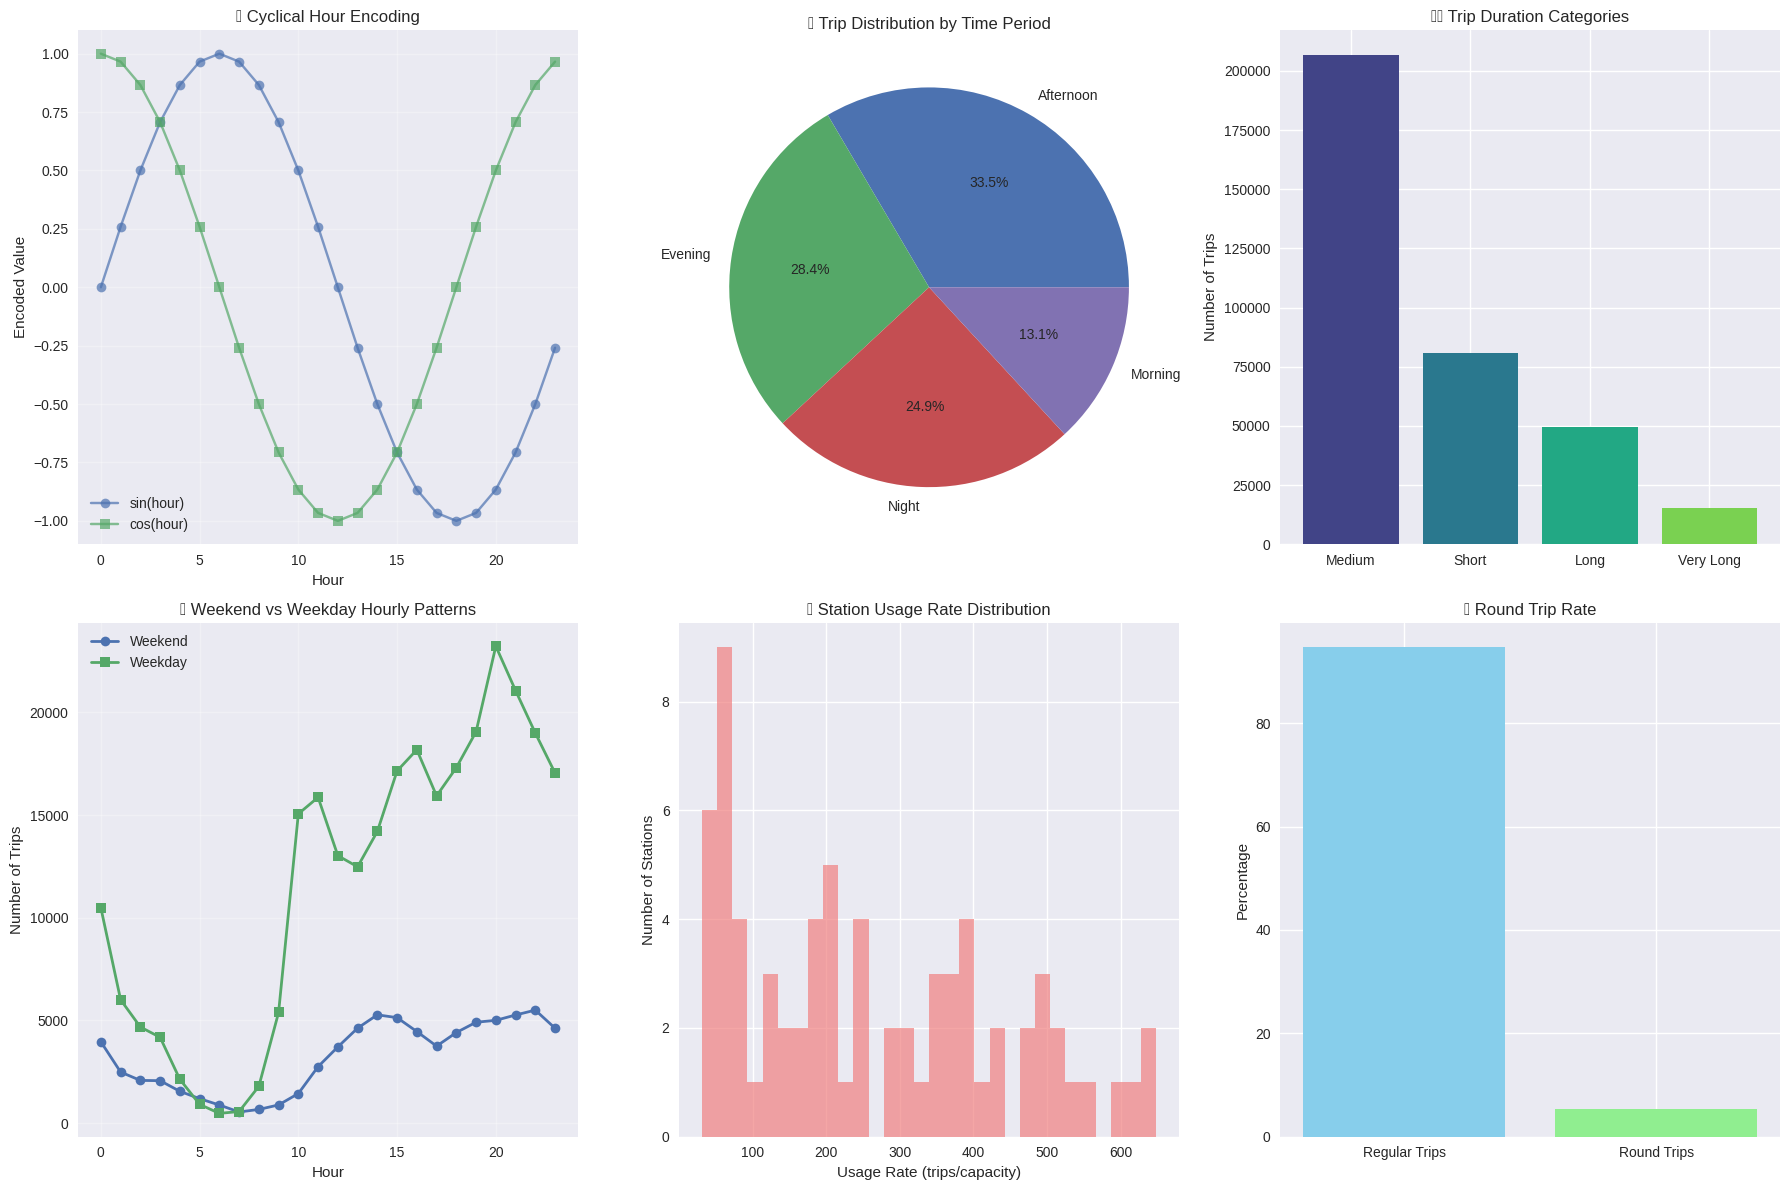

📈 Key insights from feature engineering:
   • Round trip rate: 5.3%
   • Most popular time period: Afternoon (117,914 trips)
   • Most common duration: Medium trips (206,807 trips)


In [ ]:
# Visualize the new features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Cyclical hour encoding
hours = np.arange(24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

axes[0, 0].plot(hours, hour_sin, 'o-', label='sin(hour)', alpha=0.7)
axes[0, 0].plot(hours, hour_cos, 's-', label='cos(hour)', alpha=0.7)
axes[0, 0].set_title('⭕ Cyclical Hour Encoding')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Encoded Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Time period distribution
time_period_counts = df_viajes_fe['time_period'].value_counts()
axes[0, 1].pie(time_period_counts.values, labels=time_period_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('🕐 Trip Distribution by Time Period')

# Plot 3: Duration categories
duration_counts = df_viajes_fe['duration_category'].value_counts()
axes[0, 2].bar(duration_counts.index, duration_counts.values, color=sns.color_palette("viridis", len(duration_counts)))
axes[0, 2].set_title('⏱️ Trip Duration Categories')
axes[0, 2].set_ylabel('Number of Trips')

# Plot 4: Weekend vs Weekday patterns
weekend_hourly = df_viajes_fe[df_viajes_fe['is_weekend']].groupby('origin_hour').size()
weekday_hourly = df_viajes_fe[~df_viajes_fe['is_weekend']].groupby('origin_hour').size()

axes[1, 0].plot(weekend_hourly.index, weekend_hourly.values, 'o-', label='Weekend', linewidth=2)
axes[1, 0].plot(weekday_hourly.index, weekday_hourly.values, 's-', label='Weekday', linewidth=2)
axes[1, 0].set_title('📅 Weekend vs Weekday Hourly Patterns')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Trips')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Station usage rate distribution
axes[1, 1].hist(station_features['usage_rate'], bins=30, alpha=0.7, color='lightcoral')
axes[1, 1].set_title('📊 Station Usage Rate Distribution')
axes[1, 1].set_xlabel('Usage Rate (trips/capacity)')
axes[1, 1].set_ylabel('Number of Stations')

# Plot 6: Round trip rate
round_trip_rate = df_viajes_fe['is_round_trip'].mean() * 100
axes[1, 2].bar(['Regular Trips', 'Round Trips'],
               [100 - round_trip_rate, round_trip_rate],
               color=['skyblue', 'lightgreen'])
axes[1, 2].set_title('🔄 Round Trip Rate')
axes[1, 2].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

print(f"📈 Key insights from feature engineering:")
print(f"   • Round trip rate: {round_trip_rate:.1f}%")
print(f"   • Most popular time period: {time_period_counts.index[0]} ({time_period_counts.iloc[0]:,} trips)")
print(f"   • Most common duration: {duration_counts.index[0]} trips ({duration_counts.iloc[0]:,} trips)")

#Unsupervised Learning

In [ ]:
print("🎯 UNSUPERVISED LEARNING")
print("=" * 25)

# First, let's create station clusters based on usage patterns and location
print("1️⃣ Creating station clusters...")

# Prepare features for clustering
cluster_features = station_features[[
    'lat', 'lon', 'capacity', 'total_trips', 'avg_duration',
    'unique_destinations', 'usage_rate', 'round_trip_rate', 'weekend_trip_rate'
]].copy()

# Handle any missing values
cluster_features = cluster_features.fillna(cluster_features.median())

# Standardize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(cluster_features)

print(f"   Clustering {len(cluster_features)} stations using {len(cluster_features.columns)} features")

🎯 UNSUPERVISED LEARNING
1️⃣ Creating station clusters...
   Clustering 72 stations using 9 features


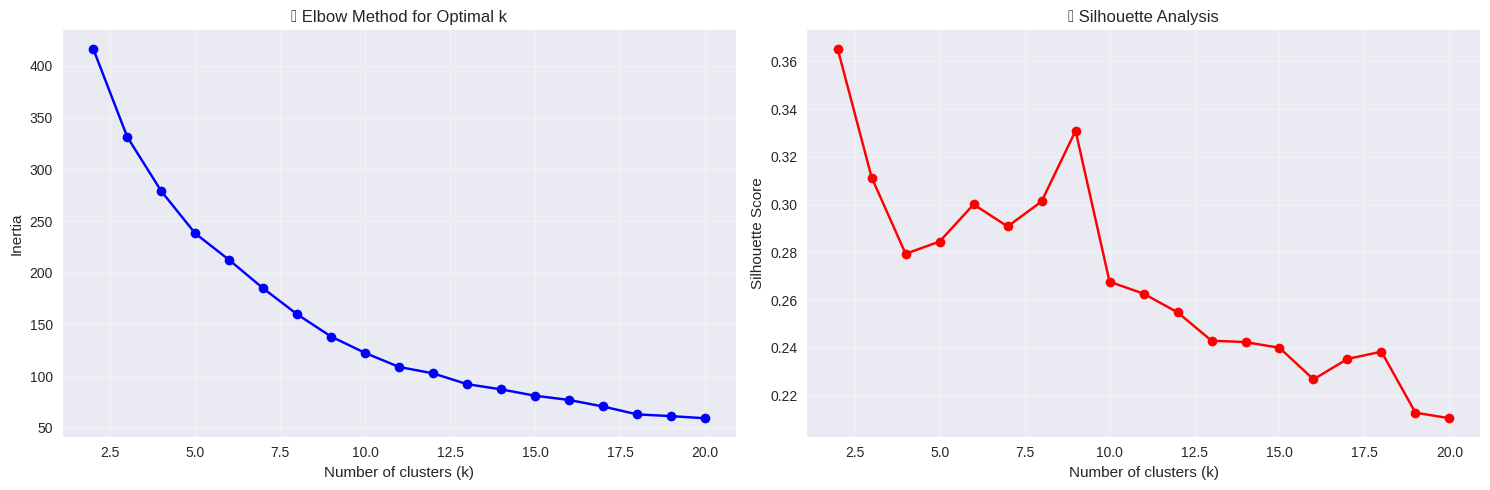

In [ ]:
inertias = []
silhouette_scores = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

    # Calculate silhouette score
    from sklearn.metrics import silhouette_score
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('📉 Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('📊 Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
optimal_k = 10
print(f"   🎯 Selected k={optimal_k} clusters")

   🎯 Selected k=10 clusters


In [ ]:
# Apply final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
station_clusters = final_kmeans.fit_predict(features_scaled)

# Add cluster labels to our station features
station_features['cluster'] = station_clusters

# Analyze clusters
print("2️⃣ Analyzing station clusters...")
cluster_analysis = station_features.groupby('cluster').agg({
    'total_trips': ['count', 'mean'],
    'avg_duration': 'mean',
    'usage_rate': 'mean',
    'capacity': 'mean',
    'unique_destinations': 'mean',
    'round_trip_rate': 'mean',
    'weekend_trip_rate': 'mean'
}).round(2)

cluster_analysis.columns = [
    'num_stations', 'avg_total_trips', 'avg_duration',
    'avg_usage_rate', 'avg_capacity', 'avg_destinations',
    'avg_round_trip_rate', 'avg_weekend_rate'
]

print("📊 Cluster Analysis:")
print(cluster_analysis)

2️⃣ Analyzing station clusters...
📊 Cluster Analysis:
         num_stations  avg_total_trips  avg_duration  avg_usage_rate  \
cluster                                                                
0                   8          3822.00         24.62          199.06   
1                   3          1001.33         35.23           50.07   
2                   1          2290.00         31.65          114.50   
3                  13          6976.62         19.38          347.14   
4                   6          3941.67         21.29          328.47   
5                   1          2513.00         37.00           59.83   
6                   2          1030.00         20.11           54.91   
7                  10          3359.70         22.87          196.20   
8                  14         10508.00         19.73          529.36   
9                  14          1203.29         29.19           61.53   

         avg_capacity  avg_destinations  avg_round_trip_rate  avg_weekend_rate  


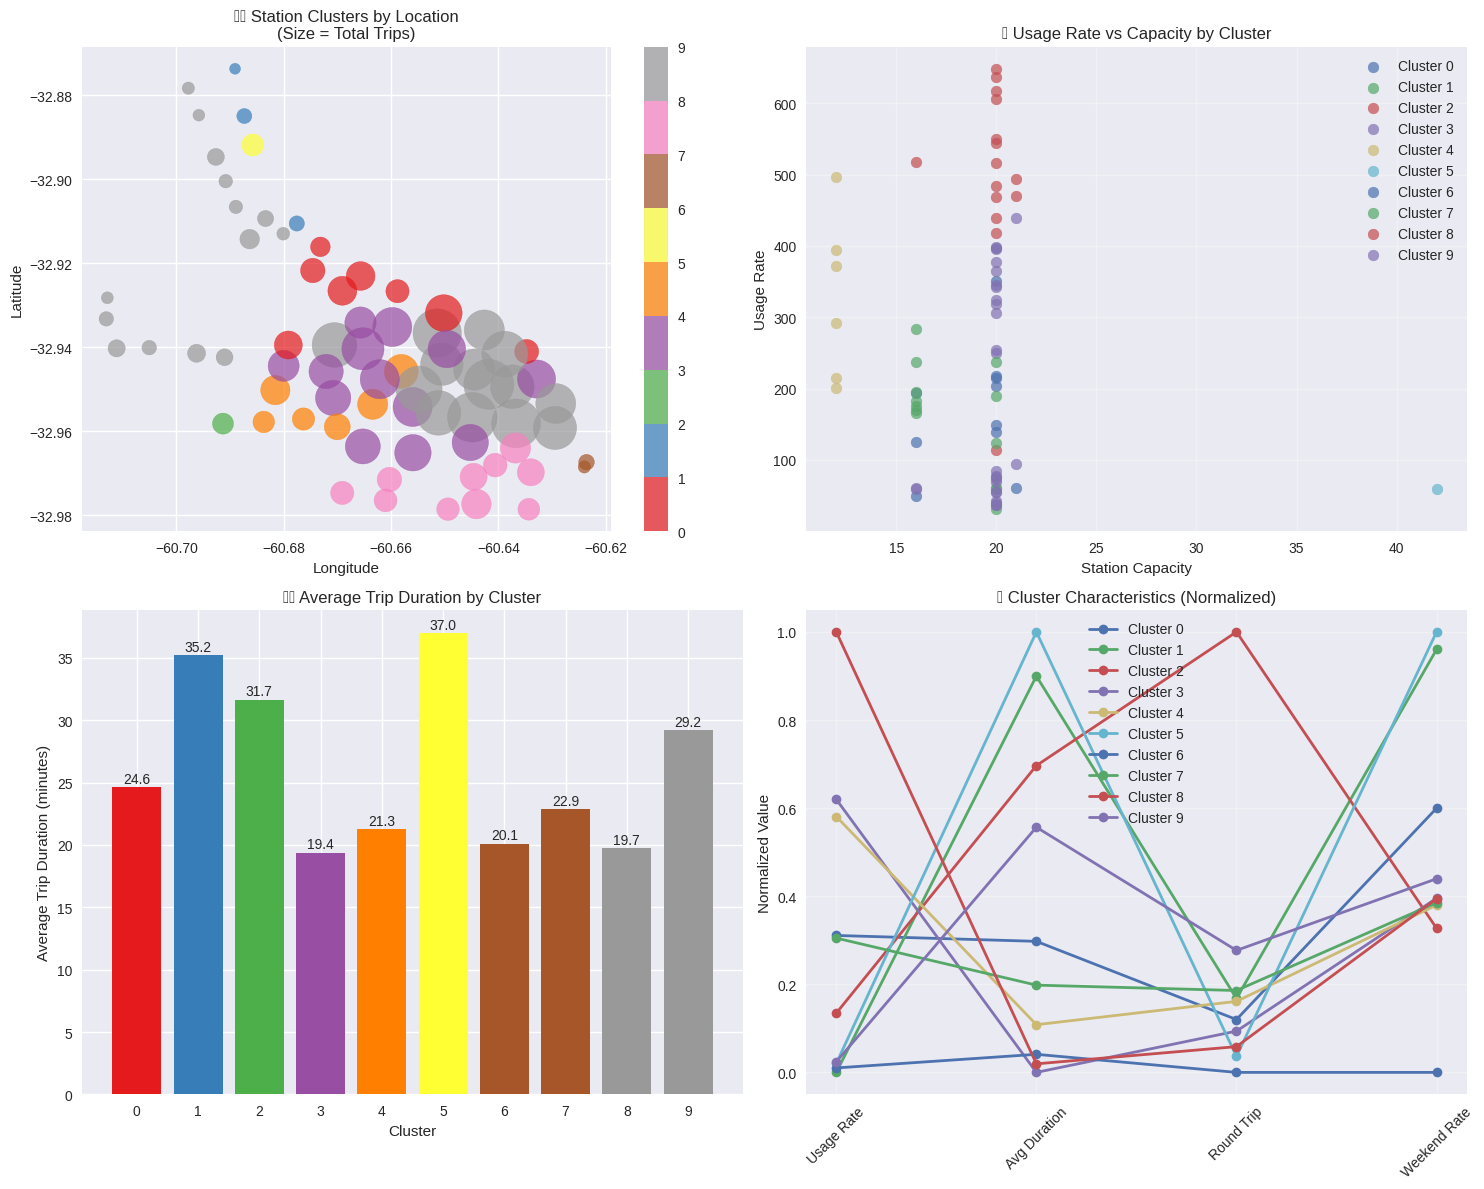

In [ ]:
# Create cluster descriptions and visualizations
cluster_descriptions = {}
colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Geographic distribution of clusters
scatter = axes[0, 0].scatter(station_features['lon'], station_features['lat'],
                            c=station_features['cluster'], cmap='Set1',
                            s=station_features['total_trips']/10, alpha=0.7)
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
axes[0, 0].set_title('🗺️ Station Clusters by Location\n(Size = Total Trips)')
plt.colorbar(scatter, ax=axes[0, 0])

# Plot 2: Usage rate vs Capacity by cluster
for cluster in range(optimal_k):
    cluster_data = station_features[station_features['cluster'] == cluster]
    axes[0, 1].scatter(cluster_data['capacity'], cluster_data['usage_rate'],
                      label=f'Cluster {cluster}', alpha=0.7, s=60)
axes[0, 1].set_xlabel('Station Capacity')
axes[0, 1].set_ylabel('Usage Rate')
axes[0, 1].set_title('💼 Usage Rate vs Capacity by Cluster')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Average trip duration by cluster
cluster_durations = station_features.groupby('cluster')['avg_duration'].mean()
bars = axes[1, 0].bar(range(optimal_k), cluster_durations.values, color=colors)
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Average Trip Duration (minutes)')
axes[1, 0].set_title('⏱️ Average Trip Duration by Cluster')
axes[1, 0].set_xticks(range(optimal_k))

# Add value labels on bars
for bar, value in zip(bars, cluster_durations.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{value:.1f}', ha='center', va='bottom')

# Plot 4: Cluster characteristics radar chart (simplified)
cluster_means = station_features.groupby('cluster')[['usage_rate', 'avg_duration', 'round_trip_rate', 'weekend_trip_rate']].mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

for cluster in range(optimal_k):
    values = cluster_means_norm.iloc[cluster].values
    axes[1, 1].plot(range(len(values)), values, 'o-', label=f'Cluster {cluster}', linewidth=2)

axes[1, 1].set_xticks(range(len(cluster_means_norm.columns)))
axes[1, 1].set_xticklabels(['Usage Rate', 'Avg Duration', 'Round Trip', 'Weekend Rate'], rotation=45)
axes[1, 1].set_ylabel('Normalized Value')
axes[1, 1].set_title('📊 Cluster Characteristics (Normalized)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


3️⃣ Discovering temporal patterns...
   Created hourly pattern matrix: (72, 24)
   PCA reduced features from 24 to 3 components
   Explained variance: 0.961


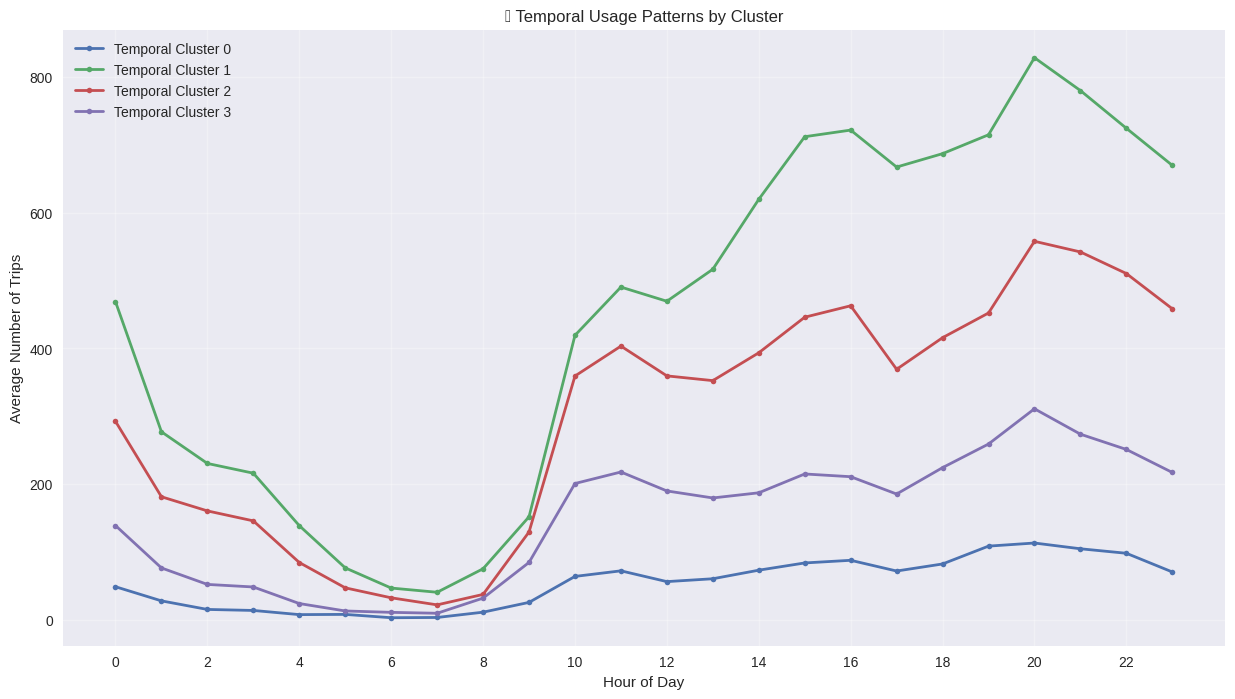

In [ ]:
print("3️⃣ Discovering temporal patterns...")

# Create hourly usage matrix for each station
hourly_patterns = df_viajes_fe.groupby(['origin_station_id', 'origin_hour']).size().unstack(fill_value=0)

print(f"   Created hourly pattern matrix: {hourly_patterns.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep 95% of variance
temporal_components = pca.fit_transform(hourly_patterns)

print(f"   PCA reduced features from {hourly_patterns.shape[1]} to {temporal_components.shape[1]} components")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Cluster temporal patterns
temporal_kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
temporal_clusters = temporal_kmeans.fit_predict(temporal_components)

# Create temporal cluster dataframe
temporal_cluster_df = pd.DataFrame({
    'origin_station_id': hourly_patterns.index,
    'temporal_cluster': temporal_clusters
})

# Analyze temporal clusters by looking at average hourly patterns
temporal_analysis = pd.DataFrame(index=range(24))
for cluster in range(4):
    cluster_stations = hourly_patterns.index[temporal_clusters == cluster]
    cluster_pattern = hourly_patterns.loc[cluster_stations].mean(axis=0)
    temporal_analysis[f'Cluster_{cluster}'] = cluster_pattern

# Visualize temporal patterns
plt.figure(figsize=(15, 8))
for cluster in range(4):
    pattern = temporal_analysis[f'Cluster_{cluster}']
    plt.plot(pattern.index, pattern.values, 'o-', label=f'Temporal Cluster {cluster}', linewidth=2, markersize=4)

plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Trips')
plt.title('🕐 Temporal Usage Patterns by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.show()

# Demand prediction model prep

In [ ]:
print("🤖 DEMAND PREDICTION PREPARATION")
print("=" * 35)

print("1️⃣ Creating demand aggregation...")

# Adjust operating hours (6 AM to 10 PM as mentioned in original code)
df_demand = df_viajes_fe.copy()

# Map late night/early morning hours to operating hours
night_hour_mapping = {
    22: 22, 23: 22,  # Late evening to 22:00
    0: 6, 1: 6, 2: 6, 3: 6, 4: 6, 5: 6  # Early morning to 6:00
}

for old_hour, new_hour in night_hour_mapping.items():
    df_demand.loc[df_demand['origin_hour'] == old_hour, 'origin_hour'] = new_hour

# Create 30-minute time slots
df_demand['time_slot'] = df_demand['origin_hour'].astype(str) + ':' + (df_demand['origin_minute'] // 30 * 30).astype(str).str.zfill(2)

print("2️⃣ Aggregating bike demand by station, date, and time...")

# Aggregate departure demand (bikes needed)
demand_departure = df_demand.groupby([
    'origin_station_id', 'origin_date', 'dia_salida', 'time_slot'
]).size().reset_index(name='bike_demand')

# Aggregate arrival demand (docks needed)
demand_arrival = df_demand.groupby([
    'destination_station_id', 'destination_date', 'dia_llegada',
    df_demand['destination_time_dt'].dt.hour.astype(str) + ':' +
    (df_demand['destination_time_dt'].dt.minute // 30 * 30).astype(str).str.zfill(2)
]).size().reset_index(name='dock_demand')

demand_arrival.columns = ['station_id', 'date', 'day', 'time_slot', 'dock_demand']
demand_departure.columns = ['station_id', 'date', 'day', 'time_slot', 'bike_demand']

print(f"   Bike demand records: {len(demand_departure):,}")
print(f"   Dock demand records: {len(demand_arrival):,}")

🤖 DEMAND PREDICTION PREPARATION
1️⃣ Creating demand aggregation...
2️⃣ Aggregating bike demand by station, date, and time...
   Bike demand records: 125,667
   Dock demand records: 149,193


In [ ]:
# Categorize demand levels
def categorize_demand(x):
    if x <= 1:
        return "Low"
    elif x <= 4:
        return "Medium"
    else:
        return "High"

demand_departure['bike_demand_category'] = demand_departure['bike_demand'].apply(categorize_demand)
demand_arrival['dock_demand_category'] = demand_arrival['dock_demand'].apply(categorize_demand)

print("3️⃣ Creating comprehensive feature set for modeling...")

3️⃣ Creating comprehensive feature set for modeling...


In [ ]:
# Add time features to demand data
demand_departure['hour'] = pd.to_datetime(demand_departure['time_slot'], format='%H:%M').dt.hour
demand_departure['minute'] = pd.to_datetime(demand_departure['time_slot'], format='%H:%M').dt.minute
demand_departure['month'] = pd.to_datetime(demand_departure['date']).dt.month
demand_departure['weekday'] = pd.to_datetime(demand_departure['date']).dt.weekday

# Add cyclical features
demand_departure['hour_sin'] = np.sin(2 * np.pi * demand_departure['hour'] / 24)
demand_departure['hour_cos'] = np.cos(2 * np.pi * demand_departure['hour'] / 24)
demand_departure['weekday_sin'] = np.sin(2 * np.pi * demand_departure['weekday'] / 7)
demand_departure['weekday_cos'] = np.cos(2 * np.pi * demand_departure['weekday'] / 7)
demand_departure['month_sin'] = np.sin(2 * np.pi * demand_departure['month'] / 12)
demand_departure['month_cos'] = np.cos(2 * np.pi * demand_departure['month'] / 12)

# Add weekend indicator
demand_departure['is_weekend'] = demand_departure['weekday'] >= 5

In [ ]:
# Merge with station features and clusters
demand_departure = demand_departure.merge(
    station_features[['origin_station_id', 'capacity', 'cluster', 'usage_rate']],
    left_on='station_id', right_on='origin_station_id', how='left'
)

# Merge with temporal clusters
demand_departure = demand_departure.merge(temporal_cluster_df, left_on='station_id', right_on='origin_station_id', how='left')

# Clean up and prepare final dataset
demand_departure = demand_departure.drop(columns=['date', 'day', 'time_slot', 'origin_station_id_x', 'origin_station_id_y'], errors='ignore')
demand_departure = demand_departure.dropna()


In [ ]:
# Clean demand_arrival in the same way
demand_arrival['hour'] = pd.to_datetime(demand_arrival['time_slot'], format='%H:%M').dt.hour
demand_arrival['minute'] = pd.to_datetime(demand_arrival['time_slot'], format='%H:%M').dt.minute
demand_arrival['month'] = pd.to_datetime(demand_arrival['date']).dt.month
demand_arrival['weekday'] = pd.to_datetime(demand_arrival['date']).dt.weekday
demand_arrival['hour_sin'] = np.sin(2 * np.pi * demand_arrival['hour'] / 24)
demand_arrival['hour_cos'] = np.cos(2 * np.pi * demand_arrival['hour'] / 24)
demand_arrival['weekday_sin'] = np.sin(2 * np.pi * demand_arrival['weekday'] / 7)
demand_arrival['weekday_cos'] = np.cos(2 * np.pi * demand_arrival['weekday'] / 7)
demand_arrival['month_sin'] = np.sin(2 * np.pi * demand_arrival['month'] / 12)
demand_arrival['month_cos'] = np.cos(2 * np.pi * demand_arrival['month'] / 12)
demand_arrival['is_weekend'] = demand_arrival['weekday'] >= 5

# Merge features
demand_arrival = demand_arrival.merge(
    station_features[['origin_station_id', 'capacity', 'cluster', 'usage_rate']],
    left_on='station_id', right_on='origin_station_id', how='left'
)

demand_arrival = demand_arrival.merge(
    temporal_cluster_df, left_on='station_id', right_on='origin_station_id', how='left'
)

# Drop unused
demand_arrival = demand_arrival.drop(columns=['date', 'day', 'time_slot', 'origin_station_id_x', 'origin_station_id_y'], errors='ignore')
demand_arrival = demand_arrival.dropna()


In [ ]:
print(f"✅ Final modeling dataset shape: {demand_departure.shape}")
print(f"   Features: {demand_departure.shape[1] - 2}")  # -2 for target variables
print(f"   Records: {demand_departure.shape[0]:,}")

# Show demand distribution
print("\n📊 Demand Distribution:")
print(demand_departure['bike_demand_category'].value_counts())
print(f"\nDemand statistics:")
print(demand_departure['bike_demand'].describe())

✅ Final modeling dataset shape: (125667, 18)
   Features: 16
   Records: 125,667

📊 Demand Distribution:
bike_demand_category
Medium    57347
Low       46875
High      21445
Name: count, dtype: int64

Demand statistics:
count    125667.000000
mean          2.803791
std           2.379048
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          44.000000
Name: bike_demand, dtype: float64


##🎯 Bayesian Hyperparameter Optimization

In [ ]:
print("🎯 BAYESIAN HYPERPARAMETER OPTIMIZATION")
print("=" * 40)

# Prepare features and target
feature_columns = [
    'station_id', 'month', 'weekday', 'hour', 'minute',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
    'is_weekend', 'cluster', 'capacity', 'usage_rate', 'temporal_cluster'
]

X = demand_departure[feature_columns].copy()
y = demand_departure['bike_demand_category'].copy()

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"📊 Data splits:")
print(f"   Training: {X_train.shape[0]:,} samples")
print(f"   Validation: {X_val.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")

# Define categorical features for CatBoost
categorical_features = ['station_id', 'month', 'weekday', 'hour', 'minute', 'cluster', 'temporal_cluster']

print(f"   Categorical features: {len(categorical_features)}")
print(f"   Numerical features: {len(feature_columns) - len(categorical_features)}")

🎯 BAYESIAN HYPERPARAMETER OPTIMIZATION
📊 Data splits:
   Training: 87,966 samples
   Validation: 18,850 samples
   Test: 18,851 samples
   Categorical features: 7
   Numerical features: 9


In [ ]:
# Bayesian optimization with Optuna
def objective(trial):
    """Objective function for Bayesian optimization"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'verbose': False,
        'random_state': 42,
        'cat_features': categorical_features
    }

    # Train model
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

    # Return validation accuracy
    return model.score(X_val, y_val)

print("🔍 Starting Bayesian optimization...")
print("   This may take several minutes...")

# Run optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=15, show_progress_bar=True)

best_params = study.best_params
best_score = study.best_value

print(f"\n🎯 Optimization Results:")
print(f"   Best validation score: {best_score:.4f}")
print(f"   Best parameters:")
for param, value in best_params.items():
    print(f"      {param}: {value}")

[I 2025-06-29 21:46:33,247] A new study created in memory with name: no-name-952ca096-131a-45b2-a94a-5e481c607939


🔍 Starting Bayesian optimization...
   This may take several minutes...


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-06-29 21:49:41,053] Trial 0 finished with value: 0.6202652519893899 and parameters: {'iterations': 250, 'depth': 7, 'learning_rate': 0.22227824312530747, 'l2_leaf_reg': 6.387926357773329, 'border_count': 66, 'bagging_temperature': 0.15599452033620265, 'random_strength': 0.5808361216819946}. Best is trial 0 with value: 0.6202652519893899.
[I 2025-06-29 21:54:58,126] Trial 1 finished with value: 0.6193103448275862 and parameters: {'iterations': 447, 'depth': 6, 'learning_rate': 0.21534104756085318, 'l2_leaf_reg': 1.185260448662222, 'border_count': 249, 'bagging_temperature': 0.8324426408004217, 'random_strength': 2.1233911067827616}. Best is trial 0 with value: 0.6202652519893899.
[I 2025-06-29 21:55:38,101] Trial 2 finished with value: 0.5988328912466844 and parameters: {'iterations': 172, 'depth': 3, 'learning_rate': 0.09823025045826593, 'l2_leaf_reg': 5.72280788469014, 'border_count': 128, 'bagging_temperature': 0.2912291401980419, 'random_strength': 6.118528947223795}. Best i

In [ ]:
# Train final CatBoost model using best parameters from Optuna
final_model_bike = CatBoostClassifier(
    **best_params,
    cat_features=categorical_features,
    random_state=42,
    verbose=False
)

final_model_bike.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate on test set
test_score_bike = final_model_bike.score(X_test, y_test)
print(f"🚴‍♀️ Final Test Accuracy (Bike Demand): {test_score_bike:.4f}")

# Save model
joblib.dump(final_model_bike, "/content/drive/MyDrive/model_bike_demand.joblib")

🚴‍♀️ Final Test Accuracy (Bike Demand): 0.6194


['/content/drive/MyDrive/model_bike_demand.joblib']

In [ ]:
# Arrival features
X = demand_arrival[feature_columns].copy()
y = demand_arrival['dock_demand_category'].copy()

In [ ]:
# Redo split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train model
final_model_dock = CatBoostClassifier(
    **best_params,
    cat_features=categorical_features,
    random_state=42,
    verbose=False
)

final_model_dock.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate
test_score_dock = final_model_dock.score(X_test, y_test)
print(f"🅿️ Final Test Accuracy (Dock Demand): {test_score_dock:.4f}")

🅿️ Final Test Accuracy (Dock Demand): 0.6189


In [ ]:
# Save
joblib.dump(final_model_dock, "/content/drive/MyDrive/model_dock_demand.joblib")

['/content/drive/MyDrive/model_dock_demand.joblib']